In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [ ]:
# Loss function for gradcam


In [2]:
def plotGradCAM(model, scenario, image_size, images_per_class = 4, trial_seed = 1, testing=True):
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    
#     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]]), 
                np.array([x[1] for x in image_sets[image_size][scenario]]), stratify= np.array([x[1] for x in image_sets[image_size][scenario]]), test_size=.2, random_state = trial_seed)

#     training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
#     training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
#     validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0)) # Sum by row
    print(validation_labels.sum(axis=0))    
    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct

    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print(output)
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier = model_modifier)#, clone=False)

    # Generate heatmap with GradCAM
    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    
    cam = gradcam(loss, gradcam_images, penultimate_layer = -4)
    cam = normalize(cam)
    print(len(cam))
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    print(cam[image_counter].shape)
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            heatmap = np.uint8(cm.jet(cam[image_counter])[..., :3] * 255)
            ax[i, j].imshow(np.squeeze(gradcam_images[image_counter], axis=2), cmap='gist_gray') #remove axes of length one from gradcam_images
            #print(heatmap.shape)
            ax[i, j].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if testing==True:
        f.savefig("../../figures/test-opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig("../../figures/opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return

In [3]:
m = models.load_model(FULL_MODEL_PATH)

In [ ]:
?Gradcam

In [3]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       5

## Plotting the filters
The code below generates the plot of the first filter in the first convolutional layer `conv2d`.
Expand it to plot all 64 filters in a grid

Reference: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [30]:
# current_filter = which filter's weights we want to see
# the total filter in previous layers will be obtained from w.shape[1]
# rows * cols > total_filters
# layer_name = 'conv2d'
def plotFilters(layer_name, current_filter = 0, normalize=False):
    layer_variables = m.get_layer(layer_name).get_weights()

    weights = layer_variables[0]
    biases = layer_variables[1]

    w = np.array(weights)
    print(w.shape)
    

    w = np.moveaxis(w, 2, 0) #what does this do?
    w = np.moveaxis(w, 3, 0) #what does this do?
    print(w.shape)

    if normalize: #scale all pixels from 0 - 1
        w_min, w_max = w.min(), w.max()
        w = (w - w_min) / (w_max - w_min)

    fig = plt.figure(figsize=(10, 10))
    
    if w.shape[0] ==64:
        rows, cols = 8, 8
    elif w.shape[0] == 128:
        rows, cols = 16, 8
    elif w.shape[0] == 256:
        rows, cols = 16, 16

    if w.shape[1] == 1: # first layer
        for filter in range(w.shape[0]):
            fig.add_subplot(rows, cols, filter+1)
            plt.imshow(w[filter][0], cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace=0, hspace=0)   
            plt.title('') #complete this
    else:
        for each_depth in range(w.shape[1]):
            fig.add_subplot(rows, cols, each_depth+1)
            plt.imshow(w[current_filter][each_depth], cmap='gray')
            plt.xticks([])
            plt.yticks([])
    # plt.savefig('../../figures/') #COMPLETE THIS, 
    return

(5, 5, 1, 64)
(64, 1, 5, 5)


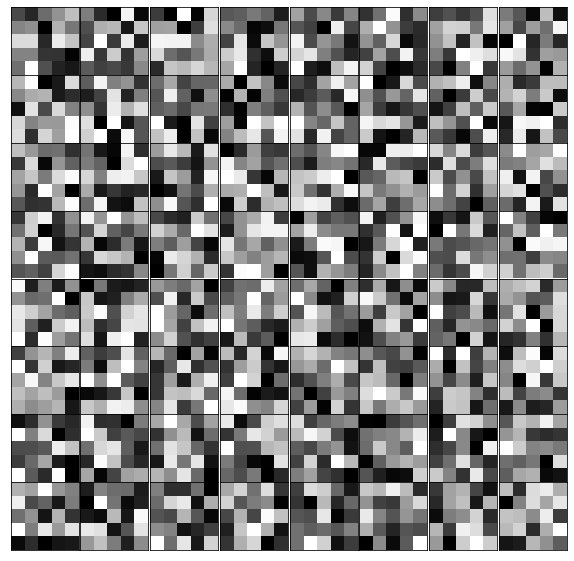

In [31]:
plotFilters('conv2d', 255)

In [76]:
def plotActivations(resolution, scenario, layer_name, cols, rows):
    """Always put docstrings for functions..."""
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    ### train/test split can be done outside function
    X_train, X_test, y_train, y_test =  train_test_split(
        np.array([np.expand_dims(x[0],axis=2) for x in image_sets[resolution][scenario]]), 
        np.array([x[1] for x in image_sets[resolution][scenario]]), 
        stratify= np.array([x[1] for x in image_sets[resolution][scenario]]), #Same distribution of the clases
        test_size = .2, 
        random_state = 1)

    
    intermediate_layer_model = models.Model(inputs=m.inputs, outputs=m.get_layer(layer_name).output)
    image = np.expand_dims(X_test[0], axis = 0) ## can be argument to function
    print("Input image shape:", image.shape)
    feature_maps = intermediate_layer_model.predict(image)

    print("Feature maps shape:", feature_maps.shape)



    output = np.squeeze(feature_maps)
    output = np.moveaxis(output, 2, 0)

    print(output.shape)


	
    # plot all 64 maps in an 8x8 squares
    if output.shape[2] == 64:
        rows, cols = 8, 8
    elif output.shape[2] == 128:
        rows, cols = 16, 8
    elif output.shape[2] == 256:
        rows, cols = 16, 16
        
    fig = plt.figure(figsize=(10, 10))
    
    ix = 1
    for i in range(rows):
        for j in range(cols):
            # specify subplot and turn of axis
            ax = plt.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            plt.subplots_adjust(wspace=0, hspace=0)   
            ix += 1
        
#     for i in range(output.shape[0]):
#         fig.add_subplot(rows, cols, i+1)
#         plt.imshow(output[i], cmap='gray')
#         plt.subplots_adjust(wspace=0, hspace=0)   
    return #good practice to always include return statements

Input image shape: (1, 128, 128, 1)
Feature maps shape: (1, 64, 64, 64)
(64, 64, 64)


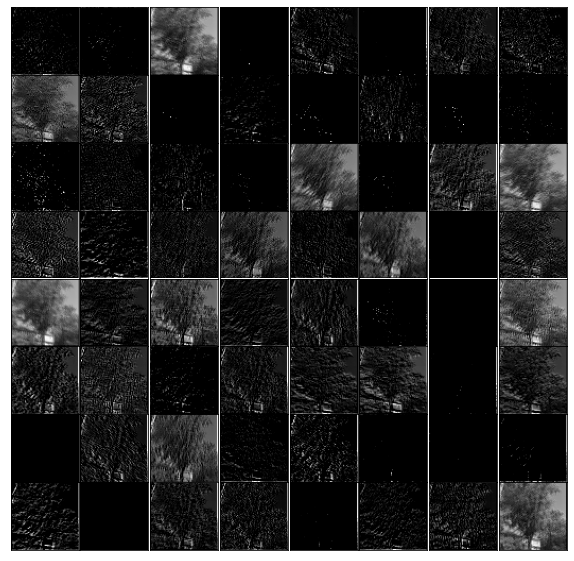

In [77]:
# [128]['PrPo_Im']
# conv2d
# cols = 8, rows = 8
plotActivations(128, 'PrPo_Im', 'conv2d', 8, 8)

To plot feature map activations, the `keract` library might be a good alternative: https://github.com/philipperemy/keract#display-the-activations-as-a-heatmap-overlaid-on-an-image

The example below still needs debugging but was adapted from: https://github.com/meet-minimalist/Visualize-CNN-Filters/blob/master/Visualize%20CNN%20Layer%20Outputs%20and%20Filters.ipynb

In [13]:
print(m.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


### First, write a function to generate the activation maximization image, then call it in a loop for the subplot

In [86]:
def generateActivationMaximization(filter_number, layer_name, seed= 101):
    def model_modifier(current_model):
        target_layer = current_model.get_layer(name=layer_name)
        new_model = tf.keras.Model(inputs=current_model.inputs,
                                   outputs=target_layer.output)
        new_model.layers[-1].activation = tf.keras.activations.linear
        return new_model
    
    
    activation_maximization = ActivationMaximization(m,
                                                     model_modifier,
                                                     )
    def loss(output):
        return output[..., filter_number]

    # Generate max activation
    activation = activation_maximization(loss, seed_input)
    print(activation[0].shape)
    image = activation[0].astype(np.uint8)
    return image

In [ ]:
### NEW
def plotActivationMaximization(layer_name): #you should just try to plot all of them for the first layer
    #for i in ##
        #for j in range...
            # ax = plt.subplot(rows, cols, ix) (just use the code from the plotActivation function)

In [81]:
def plotActivationMaximization(filter_number, layer_name):
    def model_modifier(current_model):
        target_layer = current_model.get_layer(name=layer_name)
        new_model = tf.keras.Model(inputs=current_model.inputs,
                                   outputs=target_layer.output)
        new_model.layers[-1].activation = tf.keras.activations.linear
        return new_model
    
    
    activation_maximization = ActivationMaximization(m,
                                                     model_modifier,
                                                     )
    def loss(output):
        return output[..., filter_number]

    # Generate max activation
    activation = activation_maximization(loss)
    print(activation[0].shape)
    image = activation[0].astype(np.uint8)

    # Render
    subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                     'subplot_kw': {'xticks': [], 'yticks': []} }
    f, ax = plt.subplots(**subplot_args)
    ax.imshow(np.squeeze(image, axis=2)) #squeeze dimensions
    ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    plt.tight_layout()
    plt.show()

(128, 128, 1)


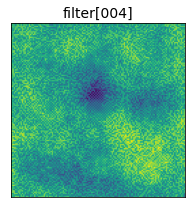

In [82]:
plotActivationMaximization(4, 'conv2d_1')

In [84]:
def plotActivationMaximizationMultiple(filter_numbers, num_images, layer_name):
    seed_input = tf.random.uniform((128, 128, 1), 0, 255)
    
    def model_modifier(current_model):
        target_layer = current_model.get_layer(name=layer_name)
        new_model = tf.keras.Model(inputs=current_model.inputs,
                                   outputs=target_layer.output)
        new_model.layers[-1].activation = tf.keras.activations.linear
        return new_model
    
    
    activation_maximization = ActivationMaximization(m,
                                                     model_modifier,
                                                     )

    # Define loss function that returns multiple filter outputs.
    def loss(output):
        return (output[..., 1], output[..., 2], output[..., 3])
    
    # Generate max activation
    activations = activation_maximization(loss,
                                          seed_input=seed_input, # To generate multiple images
                                          callbacks=[Print(interval=50)])
    images = [activation.astype(np.uint8) for activation in activations]
    # Render
    subplot_args = { 'nrows': 1, 'ncols': num_images, 'figsize': (9, 3),
                     'subplot_kw': {'xticks': [], 'yticks': []} }
    f, ax = plt.subplots(**subplot_args)
    for i, filter_number in enumerate(filter_numbers):
        ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
        ax[i].imshow(np.squeeze(images[i], axis=2))
    plt.tight_layout()
    #plt.savefig('../../figures/visualize-filters')
    plt.show()
    

In [ ]:
plotActivationMaximizationMultiple([1, 2, 3], 3, 'conv2d_1')

In [ ]:
#image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
plotGradCAM(m, "PrPo_Im", 128, images_per_class = 2, trial_seed = 21,  testing=True)

In [ ]:
def plotSaliency(model, scenario, image_size, images_per_class = 4, trial_seed = 1, saliency=False, testing=True):
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0))
    print(validation_labels.sum(axis=0))    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct
    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    

    saliency = Saliency(model, model_modifier=model_modifier)#                    clone=False)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, gradcam_images, 
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.
    saliency_map = normalize(saliency_map)
    #image_titles = class_labels
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            ax[i, j].imshow(saliency_map[image_counter], cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if testing == True:
        f.savefig("../../figures/test-opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig("../../figures/opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return



In [ ]:
plotSaliency(m, "PrPo_Im", 128, images_per_class = 2, trial_seed = 21,  testing=True)

In [ ]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()